In [309]:
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import *
from matplotlib.dates import DateFormatter
import warnings
warnings.filterwarnings("ignore")
import copy


In [482]:
###covid lab results from here https://data.gov.il/dataset/covid-19 file named "נתוני קורונה בדיקות מעבדה"
covid_data_path = "D:\\אישי\\תמותת יתר\\covid data\\corona_lab_tests_030120.csv"

#parsing covid data as in "C:\\Users\\omrip\\Downloads\\corona_lab_tests_ver_00103.csv"
covid_data = pd.read_csv(covid_data_path, encoding="utf-8")
covid_data["result_date"] = pd.to_datetime(covid_data["result_date"]).dt.to_period('w')

#filtering only conclusive results
covid_data = covid_data[covid_data["corona_result"].isin(["שלילי","חיובי"])]
covid_data_agg = covid_data.groupby(by = ["corona_result","result_date"]).count()


#number of positive results
positive_covid_data_agg = covid_data_agg.loc[(slice("חיובי"), slice(None)), :]
positive_covid_data_agg.index = [index[1] for index in positive_covid_data_agg.index]
positive_covid_data_agg = positive_covid_data_agg.iloc[:,0]
positive_covid_data_agg.name = "positive covid results"

#find the number of covid tests
covid_data_sum = covid_data_agg.groupby(by = "result_date").sum()
covid_data_sum = covid_data_sum.iloc[:,0]
covid_data_sum.name = "all covid tests"

#find the positive precentage
pos_precentage = np.divide(positive_covid_data_agg, covid_data_sum)


all_covid_data = pd.concat((positive_covid_data_agg, covid_data_sum, pos_precentage), axis = 1)
all_covid_data.columns = ["all_covid_data", "all covid tests", "positive rate"]

all_covid_data["date"] = all_covid_data.index
all_covid_data["last week covid cases"] = 0
all_covid_data["last week covid tests"] = 0
all_covid_data["last week positive rate"] = 0
for i in range(1, all_covid_data.shape[0]):
    all_covid_data["last week covid cases"].iloc[i] = all_covid_data["all_covid_data"].iloc[i - 1] 
    all_covid_data["last week covid tests"].iloc[i] = all_covid_data["all covid tests"].iloc[i - 1]
    all_covid_data["last week positive rate"].iloc[i] = all_covid_data["positive rate"].iloc[i - 1]
    

#covid deaths
covid_detailed_path = "D:\\אישי\\תמותת יתר\\covid data\\corona_age_and_gender_ver_0046.csv"

covid_detailed_data = pd.read_csv(covid_detailed_path, encoding="utf-8")
covid_detailed_data["last_week_day"] = pd.to_datetime(covid_detailed_data["last_week_day"]).dt.to_period('w')
covid_detailed_data = covid_detailed_data.drop(labels = ["first_week_day", "age_group", "gender", "weekly_tests_num",
                                  "weekly_newly_tested", "weekly_cases"], axis = 1)


covid_data_agg = covid_detailed_data.groupby(by = ["last_week_day"]).sum()

In [313]:
###Flu data from flunet https://www.who.int/influenza/gisrs_laboratory/flunet/en/
flu_data_path = "D:\\אישי\\תמותת יתר\\flu data\\FluNetInteractiveReport.csv"
flu_data = pd.read_csv(flu_data_path, header = 1)
flu_data["Start date"] = pd.to_datetime(flu_data["Start date"]).dt.to_period('w').sort_values()
flu_data["Total number of influenza positive viruses"] = flu_data["Total number of influenza positive viruses"].fillna(0)
flu_data = flu_data.groupby(by = "Start date").sum()
flu_data.columns = ["confirmed flu cases"]

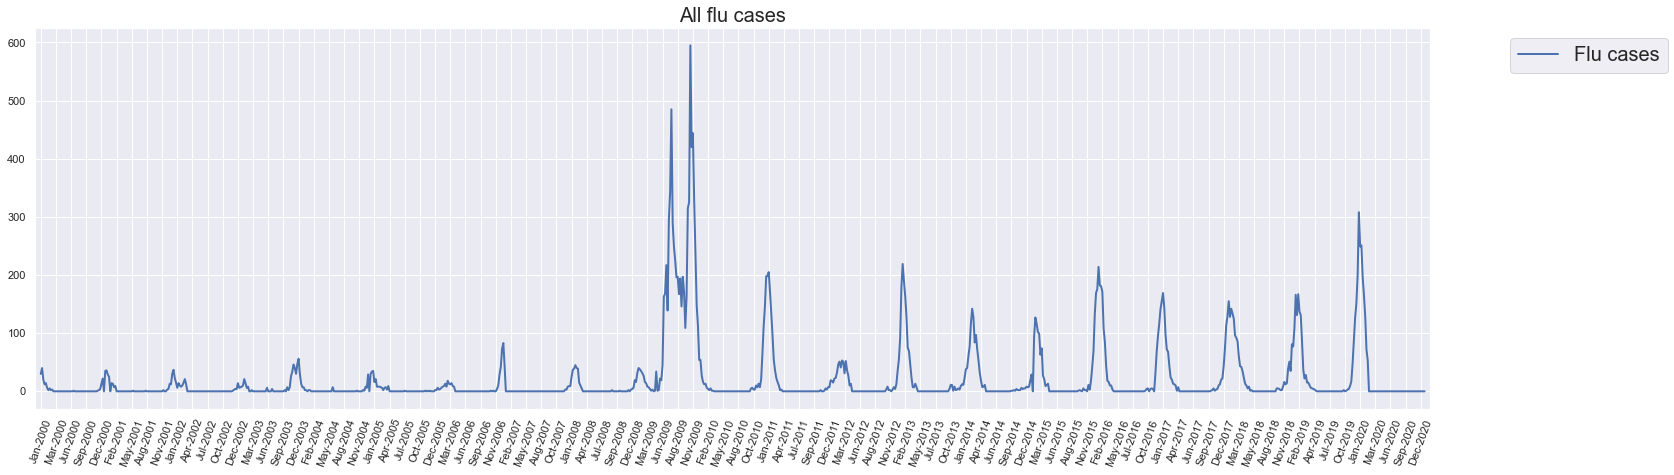

In [503]:
##Flu figure

cur_data_point = datetime.datetime(2000, 1, 3)
date_form = DateFormatter("%b-%Y")
degrees = 70

times = []


for i in range(np.array(flu_data).shape[0]):
    times.append(cur_data_point)

    cur_data_point = cur_data_point + relativedelta(days =7)

    
min_time = times[0] + relativedelta(months = -1)
max_time = times[-1] + relativedelta(months = 1)
    
    
# flu cases figure
fig = plt.figure()
ax = plt.gca()
plt.plot(times, np.array(flu_data), label = "Flu cases", linewidth = 2)

fig.set_size_inches(25, 7)
ax.xaxis.set_major_formatter(date_form)
ticks_to_show = [times[i] for i in range(len(times)) if i % 12 == 0]
plt.xticks(ticks_to_show, rotation=degrees)
plt.xlim((min_time, max_time))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  prop={'size': 20})
plt.title("All flu cases", fontsize=20, ha='center')
sns.set()
plt.show()

In [655]:
def get_var_mat_and_death_vec(path, pop_size_path):
    """
    path - the location of the weekly death data. it should contain 3 columns: date,count,week
    pop_size_path -the location of the monthly population size. columns: date, size
    returns:
    the matrix with all the variables, the corresponding death count vector and the corresponding dates
    """
    #read death count
    cur_death_count = pd.read_csv(path, header= 0)
    tmp_weeks = pd.to_datetime(cur_death_count["date"]).dt.to_period('w').sort_values()
    tmp_weeks.index = [i for i in range(tmp_weeks.shape[0])]
    cur_death_count["date"] = tmp_weeks
    #add intercept 
    cur_death_count["intercept"] = 1

    #read the population size file
    pop_size = pd.read_csv(pop_size_path, header= 0)
    tmp_months = pd.to_datetime(pop_size["date"], format = "%d/%m/%Y").dt.to_period('M').sort_values()
    tmp_months.index = [i for i in range(tmp_months.shape[0])]
    pop_size["date"] = tmp_months
    pop_size["year"] = pop_size["date"].dt.year
    pop_size["month"] = pop_size["date"].dt.month

    #add population vector to data
    pop_size_vec = []
    for i in range(cur_death_count.shape[0]):
        cur_tmp_date = cur_death_count["date"].iloc[i]
        cur_pop_to_select = (pop_size["month"] == cur_tmp_date.month) & (pop_size["year"] == cur_tmp_date.year)
        pop_size_vec.append(float(pop_size["size"][cur_pop_to_select]))
    cur_death_count["pop size"] = pop_size_vec



    #add one hot vector for seasons
    cur_death_count["spring"] = 0
    cur_death_count["summer"] = 0
    cur_death_count["fall"] = 0
    cur_death_count["winter"] = 0

    spring_mask = (3 <=cur_death_count["date"].dt.month) & (cur_death_count["date"].dt.month <= 5)
    summer_mask = (6 <=cur_death_count["date"].dt.month) & (cur_death_count["date"].dt.month <= 8)
    fall_mask = (9 <=cur_death_count["date"].dt.month) & (cur_death_count["date"].dt.month <= 11)
    winter_mask = (12 <=cur_death_count["date"].dt.month) | (cur_death_count["date"].dt.month <= 2)

    cur_death_count["spring"][spring_mask] = 1
    cur_death_count["summer"][summer_mask] = 1
    cur_death_count["fall"][fall_mask] = 1
    cur_death_count["winter"][winter_mask] = 1


    #add one hot vector for each month:
    for i in range(1, 13):
        month_to_add = cur_death_count["date"].dt.month == i
        cur_death_count["month %d" % i] = 0
        cur_death_count["month %d" % i][month_to_add] = 1


    #add one hot vector for each week
    for i in range(1, 54):
        week_to_add = cur_death_count["week"] == i
        cur_death_count["week %d" % i] = 0
        cur_death_count["week %d" % i][week_to_add] = 1
        
    #add covid and flu data
    cur_death_count = pd.merge(cur_death_count, all_covid_data, how = "left", on = "date")
    flu_data_copy = copy.deepcopy(flu_data)
    flu_data_copy["date"] = flu_data_copy.index
    cur_death_count = pd.merge(cur_death_count, flu_data_copy, how = "left", on = "date")
    cur_death_count = cur_death_count.fillna(0)

    only_death_count_data = np.array(cur_death_count["count"])
    only_dates = cur_death_count["date"]
    cur_death_count = cur_death_count.drop(labels = ["date", "count", "week"], axis = 1)
    return cur_death_count, only_death_count_data, only_dates


def calc_prediction(model, cur_variables, real_death_count):
    """
    gets a model, list of variables and real death count
    returns list of predictions, Z-score and time for each data point
    """

    cur_data_point = datetime.datetime(2000, 1, 3)


    times = []
    predictions = []

    for i in range(cur_variables.shape[0]):
        times.append(cur_data_point)
        predictions.append(poi_model_res.predict(np.array(cur_variables.iloc[i, :]).T)[0])
        cur_data_point = cur_data_point + relativedelta(days =7)

    z_score = [(real_death_count[i] - predictions[i])/(predictions[i] ** 0.5) for i in range(len(predictions))]
    
    return predictions, z_score, times

def draw_model(predictions, real_death_count, times):
    """
    gets a list of predictions and their corresponding real data count and times
    draws the predictions, real death count and the excess mortality over time
    """
    min_time = times[0] + relativedelta(months = -1)
    max_time = times[-1] + relativedelta(months = 1)
    date_form = DateFormatter("%b-%Y")
    degrees = 70
    fig = plt.figure()
    ax = plt.gca()
    plt.plot(times, predictions, label = "Model prediction", linewidth = 2)
    plt.plot(times, real_death_count, label = "True data", linewidth = 2)
    ax.fill_between(x = times, y1 = predictions, y2 = real_death_count, color = "lightgreen", 
                    where = [predictions[i] >=real_death_count[i]  for i in range(len(predictions))], interpolate = True, 
                    label = "Low than expected mortality", alpha  = 1)

    ax.fill_between(x = times, y1 = predictions, y2 = real_death_count, color = "lightcoral", 
                    where = [predictions[i] <real_death_count[i]  for i in range(len(predictions))], interpolate = True, 
                    label = "Excess mortality", alpha  = 0.6)


    fig.set_size_inches(25, 7)
    ax.xaxis.set_major_formatter(date_form)
    ticks_to_show = [times[i] for i in range(len(times)) if i % 16 == 0]
    plt.xticks(ticks_to_show, rotation=degrees)
    plt.xlim((min_time, max_time))
    ax.axvspan(times[-12], max_time, alpha=0.3, color = "yellow", label = "Recent data - not final")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  prop={'size': 20})
    plt.title("Real Data & Model Prediction", fontsize=20, ha='center')
    sns.set()
    plt.show()
    

def draw_z_score(z_score, times):
    """
    gets a list of z-scores and their corresponding real data count and times
    draws the z scores over time
    """
    min_time = times[0] + relativedelta(months = -1)
    max_time = times[-1] + relativedelta(months = 1)
    
    fig = plt.figure()
    plt.plot(times, z_score, marker = ".", label = "Z-score" )
    fig.set_size_inches(20, 7)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(date_form)

    ticks_to_show = [times[i] for i in range(len(times)) if i % 16 == 0]
    plt.xticks(ticks_to_show, rotation=degrees)

    plt.plot((min_time, max_time), [8, 8], label = "Extremely substantial increase" ,color = "darkred", linestyle = ":" )
    plt.plot((min_time, max_time), [3, 3], label = "Substantial increase\decrease" ,color = "red", linestyle = ":" )
    plt.plot((min_time, max_time), [-3, -3],color = "red", linestyle = ":" )
    plt.plot((min_time, max_time), [0,0], label = "baseline" ,color = "grey", linestyle = ":" )

    plt.xlim((min_time, max_time))
    plt.ylim((-8, 14))


    ax.fill_between((min_time, max_time), -1.5 , 1.5, alpha=0.3, color = "grey", label = "Normal range")
    ax.axvspan(times[-12], max_time, alpha=0.3, color = "yellow", label = "Recent data - not final")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  prop={'size': 15})
    plt.title("Excess Mortality Z-Score", fontsize=20, ha='center')
    sns.set()
    plt.show()
    
def top_alpha_excess_mortality(z_score, times, alpha):
    """
    gets list of z score and corresponding times
    draws for each year the alpha precent of highest z scores grouped by year
    """
    z_score_df = pd.DataFrame(z_score)
    z_score_df.columns = ["Z-score count"]
    z_score_df["year"] = times
    z_score_df = z_score_df.sort_values(by = "Z-score count", ascending = False)                                                
    z_score_df["year"] = z_score_df["year"] = z_score_df["year"].dt.year
    z_score_df = z_score_df.iloc[:int(alpha * len(z_score))].groupby(by = "year").count()


    plt.figure()
    degrees = 70
    ax = plt.gca()
    sns.barplot(z_score_df.index, z_score_df["Z-score count"])
    fig.set_size_inches(25, 7)
    plt.xticks(rotation=degrees, size = "large")
    plt.show()

def write_young_pop(all_pop_path, elderly_pop_path, output_loc):
    """
    gets all population and elderly population data path and output file path
    writes the size of the young population in the ouput path
    """
    all_pop_df = pd.read_csv(all_pop_path, header = 0)
    elderly_pop_df = pd.read_csv(elderly_pop_path, header = 0)


    young_pop_df = copy.deepcopy(all_pop_df["date"])
    young_pop_size = pd.to_numeric(all_pop_df["size"]) - pd.to_numeric(elderly_pop_df["size"])
    young_pop_size = pd.concat((young_pop_df, young_pop_size), axis = 1)
    young_pop_size.to_csv(output_loc, index = False)
    
def write_young_death(all_pop_death_path, elderly_death_count_path, death_output_loc):
    """
    gets all population and elderly death count data path and output file path
    writes the count of the young deaths in the ouput path
    """
    all_death_df = pd.read_csv(all_pop_death_path, header = 0)
    elderly_death_df = pd.read_csv(elderly_death_count_path, header = 0)

    young_death = pd.to_numeric(all_death_df["count"]) - pd.to_numeric(elderly_death_df["count"])
    young_death_df = copy.deepcopy(all_death_df)
    young_death_df["count"] = young_death
    young_death_df.to_csv(death_output_loc, index = False)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1092
Model:                            GLM   Df Residuals:                     1027
Model Family:                 Poisson   Df Model:                           64
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6195.8
Date:                Mon, 11 Jan 2021   Deviance:                       3114.4
Time:                        22:37:56   Pearson chi2:                 3.17e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4664      0.007    632.720      0.0

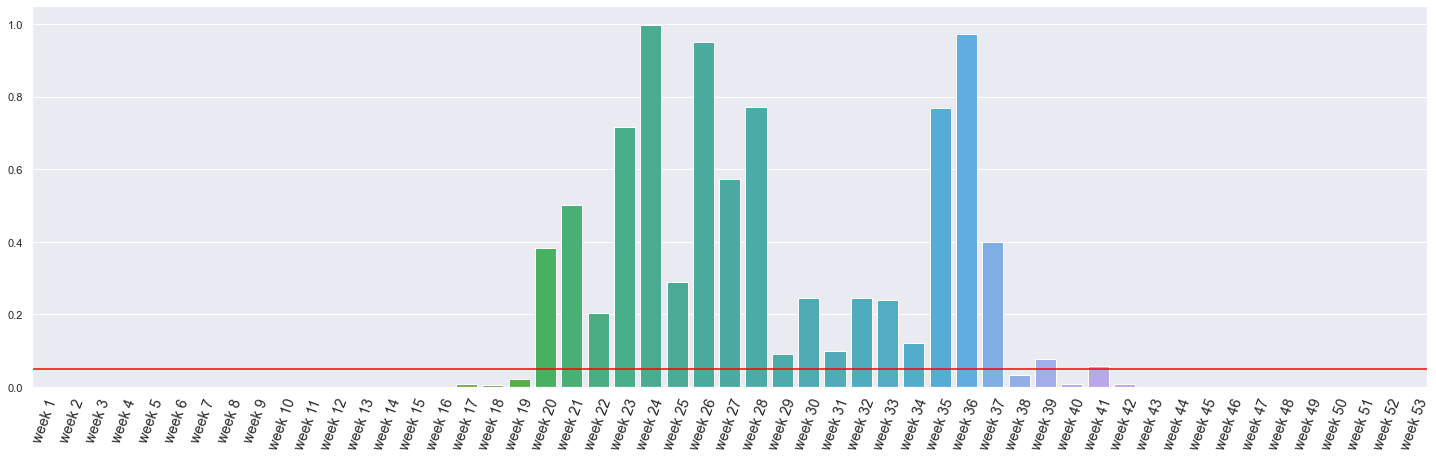

In [642]:
#############################
##  All population model   ##
#############################

# Index([0- intercept, 1 -'pop size', 
#2 - 5'spring', 'summer', 'fall', 'winter', 
#6 - 17 'month 1', 'month 2', #        'month 3', 'month 4', 'month 5', 'month 6', 'month 7', 'month 8', 'month 9', 'month 10', 'month 11', 'month 12',
# 18 - 70'week 1', 'week 2','week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9',
#        'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15',
#        'week 16', 'week 17', 'week 18', 'week 19', 'week 20', 'week 21',
#        'week 22', 'week 23', 'week 24', 'week 25', 'week 26', 'week 27',
#        'week 28', 'week 29', 'week 30', 'week 31', 'week 32', 'week 33',
#        'week 34', 'week 35', 'week 36', 'week 37', 'week 38', 'week 39',
#        'week 40', 'week 41', 'week 42', 'week 43', 'week 44', 'week 45',
#        'week 46', 'week 47', 'week 48', 'week 49', 'week 50', 'week 51',
#        'week 52', 'week 53', 
# 71'all_covid_data',  72 'all covid tests', 73'positive rate', 74'last week covid cases',  75 'last week covid tests',
#        76 'last week positive rate', 77 'confirmed flu cases']

#parsing data
all_pop_death_path = "D:\\אישי\\תמותת יתר\\death numbers\\death all age 291220.csv"
all_pop_size_path = "D:\\אישי\\תמותת יתר\\pop size\\all pop size.csv"
variables, death_count, times = get_var_mat_and_death_vec(all_pop_death_path, all_pop_size_path)

#poi model 
poi_model = sm.GLM(death_count, np.array(variables.iloc[:, :71]), family=sm.families.Poisson())
poi_model_res = poi_model.fit()
print(poi_model_res.summary())



#plot weeks p values
degrees = 70
fig = plt.figure()
ax = plt.gca()
sns.barplot(variables.columns[18:71], poi_model_res.pvalues[18:])
fig.set_size_inches(25, 7)
plt.xticks(rotation=degrees, size = "large")
plt.axhline(0.05, color = "red")

plt.show()

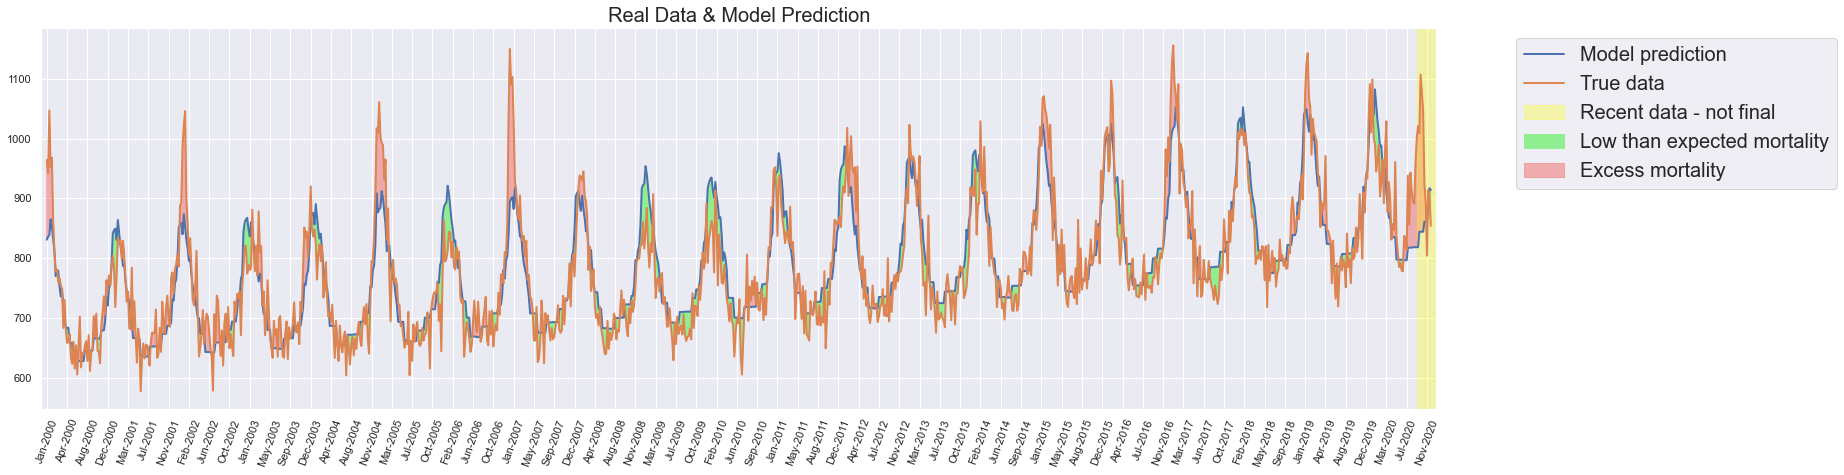

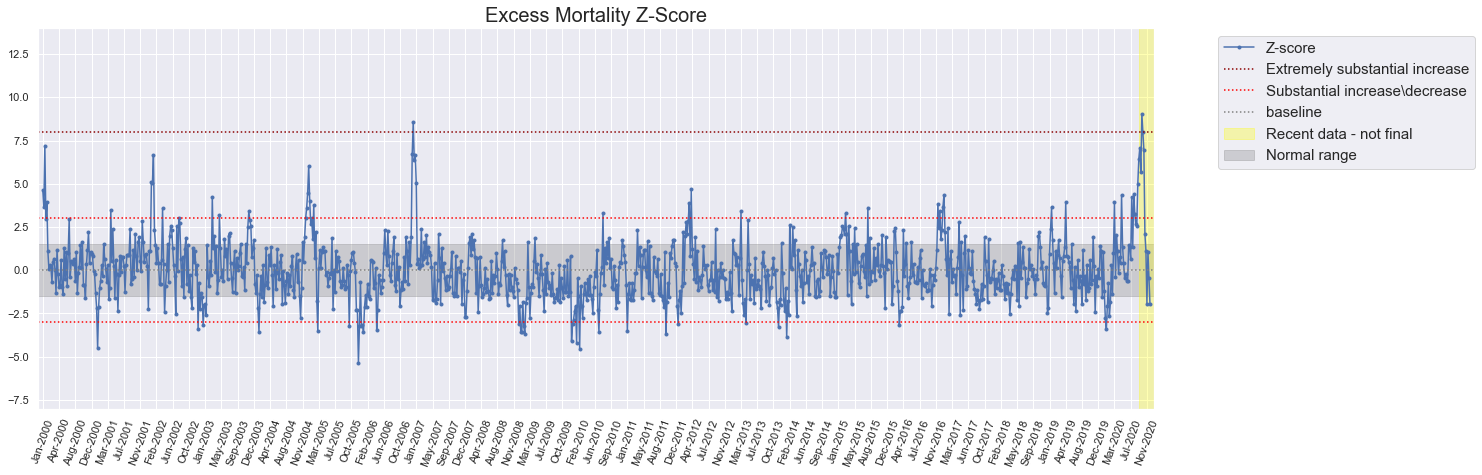

<Figure size 432x288 with 0 Axes>

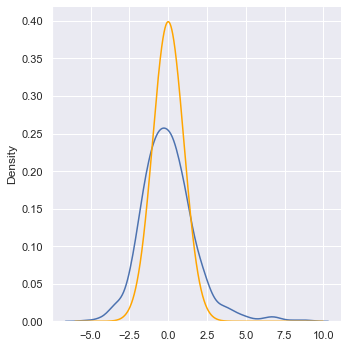

,Z score,times
1083,9.04946,2020-10-05
365,8.55812,2007-01-01
1084,7.98245,2020-10-12
2,7.21031,2000-01-17
1081,7.08966,2020-09-21
1085,6.94985,2020-10-19
364,6.72618,2006-12-25
367,6.68587,2007-01-15
109,6.65681,2002-02-04
1080,6.42543,2020-09-14


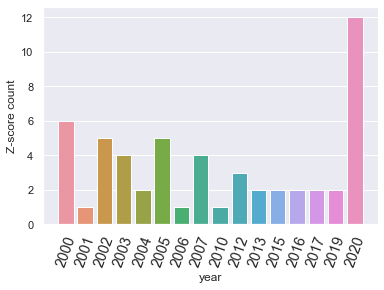

In [654]:
###################################
##  All population model         ##
## not including low P-val weeks ##
###################################


#After removing some weeks, other weeks became less significant, so I removed them as well


updated_variables = pd.concat((variables.iloc[:,:33],variables.iloc[:,64:71]), axis = 1)
poi_model = sm.GLM(death_count, np.array(updated_variables), family=sm.families.Poisson())
poi_model_res = poi_model.fit()
poi_model_res.summary()

predictions, z_score, times = calc_prediction(poi_model_res, updated_variables, death_count)
draw_model(predictions, death_count, times)
draw_z_score(z_score, times)

plt.figure()
norm_vals = [i / 100 for i in range(-600, 1000)]
sns.displot(z_score, kind="kde", label = "Z score")
plt.plot(norm_vals,scipy.stats.norm.pdf(norm_vals), label = "Normal PDF", color = "orange")
plt.show()

#top 5 percent excess mortality 
top_alpha_excess_mortality(z_score, times, 0.05)

all_z_score_and_time = pd.DataFrame([z_score, times], index = ["Z score", "times"]).T
all_z_score_and_time = all_z_score_and_time.sort_values(by = "Z score", ascending=False)
all_z_score_and_time.iloc[:20]

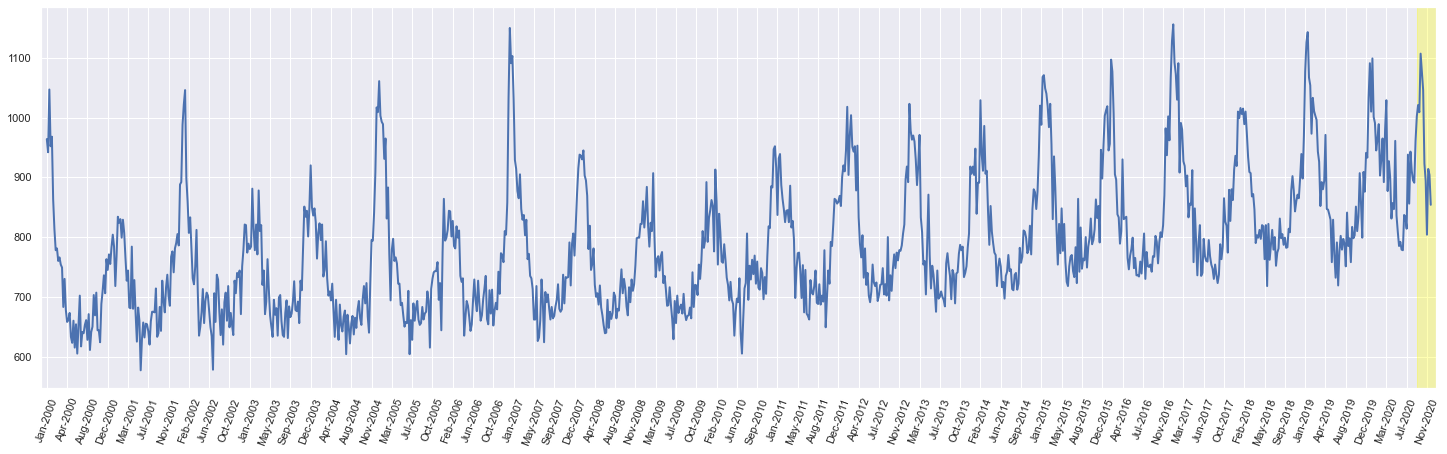

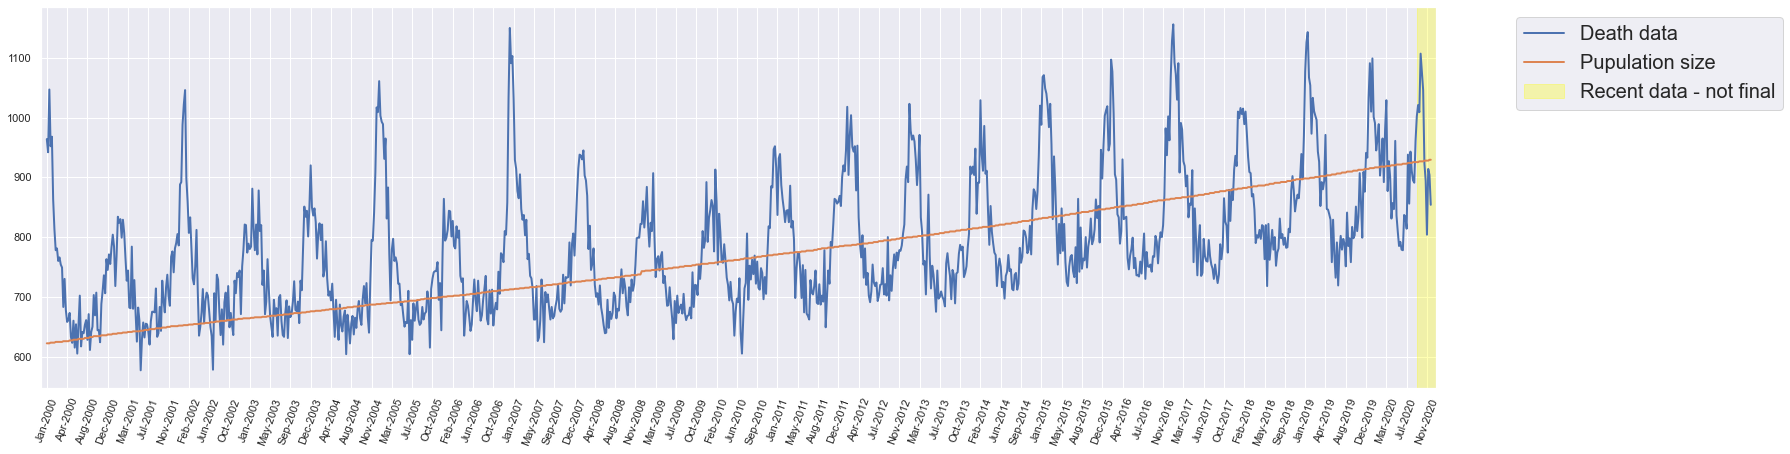

In [646]:
#plot all death

min_time = times[0] + relativedelta(months = -1)
max_time = times[-1] + relativedelta(months = 1)
date_form = DateFormatter("%b-%Y")
degrees = 70
fig = plt.figure()
ax = plt.gca()

plt.plot(times[:], real_death_count, label = "True data", linewidth = 2)

fig.set_size_inches(25, 7)
ax.xaxis.set_major_formatter(date_form)
ticks_to_show = [times[i] for i in range(len(times)) if i % 16 == 0]
plt.xticks(ticks_to_show, rotation=degrees)
plt.xlim((min_time, max_time))
ax.axvspan(times[-12], max_time, alpha=0.3, color = "yellow", label = "Recent data - not final")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  prop={'size': 20})
sns.set()
plt.show()


fig = plt.figure()
ax = plt.gca()

plt.plot(times[:], real_death_count, label = "Death data", linewidth = 2)
plt.plot(times[:], variables.loc[:,"pop size"] / 10, label = "Pupulation size", linewidth = 2)

fig.set_size_inches(25, 7)
ax.xaxis.set_major_formatter(date_form)
ticks_to_show = [times[i] for i in range(len(times)) if i % 16 == 0]
plt.xticks(ticks_to_show, rotation=degrees)
plt.xlim((min_time, max_time))
ax.axvspan(times[-12], max_time, alpha=0.3, color = "yellow", label = "Recent data - not final")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  prop={'size': 20})
sns.set()
plt.show()




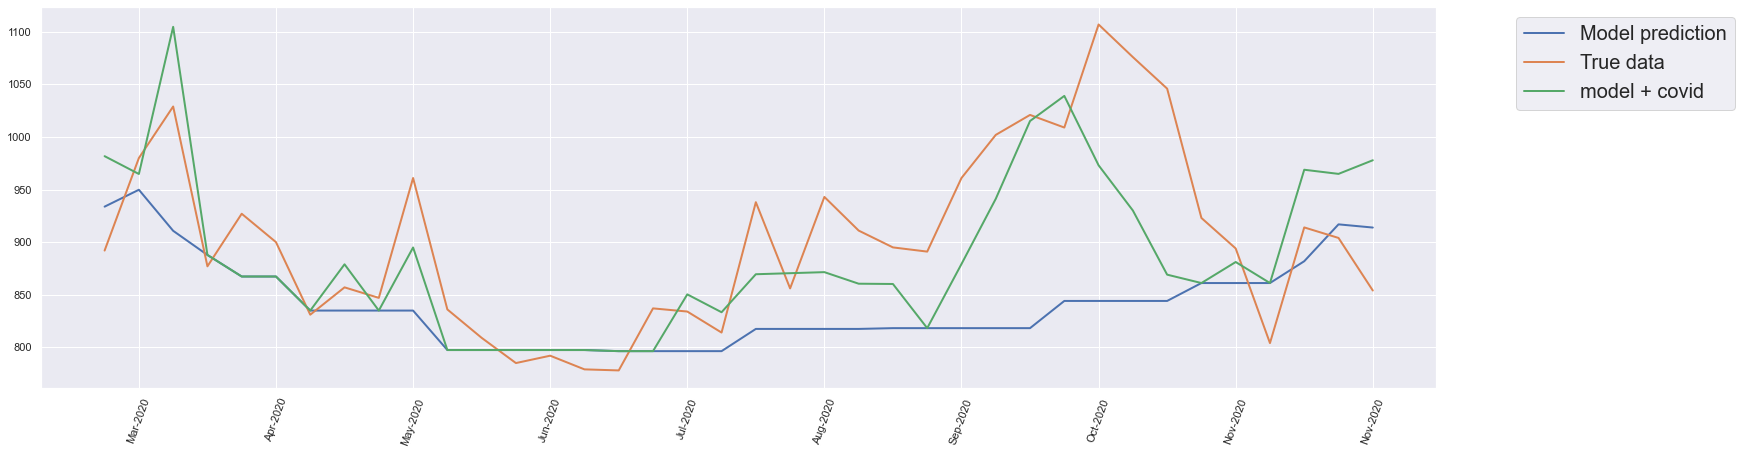

In [486]:
last_time_points = 38


date_form = DateFormatter("%b-%Y")
degrees = 70
fig = plt.figure()
ax = plt.gca()
plt.plot(times[-last_time_points:], predictions[-last_time_points:], label = "Model prediction", linewidth = 2)
plt.plot(times[-last_time_points:], real_death_count[-last_time_points:], label = "True data", linewidth = 2)
plt.plot(times[-last_time_points:], np.array(predictions[-last_time_points:]) + np.array(covid_data_agg["weekly_deceased"]), label = "model + covid", linewidth = 2 )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  prop={'size': 20})
fig.set_size_inches(25, 7)
ax.xaxis.set_major_formatter(date_form)
ticks_to_show = [times[-i - 1] for i in range(len(times[-last_time_points:])) if i % 4 == 0]
ticks_to_show.reverse()
plt.xticks(ticks_to_show, rotation=degrees)
sns.set()
plt.show()
    



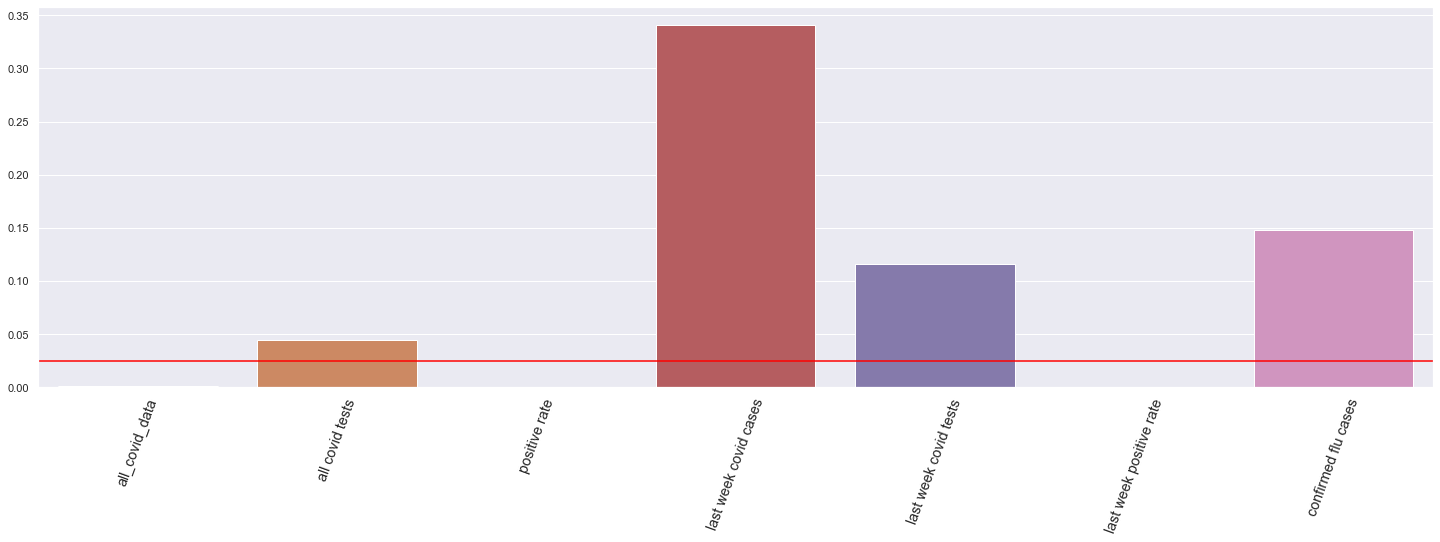

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1092
Model:                            GLM   Df Residuals:                     1054
Model Family:                 Poisson   Df Model:                           37
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6026.3
Date:                Tue, 05 Jan 2021   Deviance:                       2775.2
Time:                        22:24:24   Pearson chi2:                 2.80e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5278      0.008    572.836      0.0

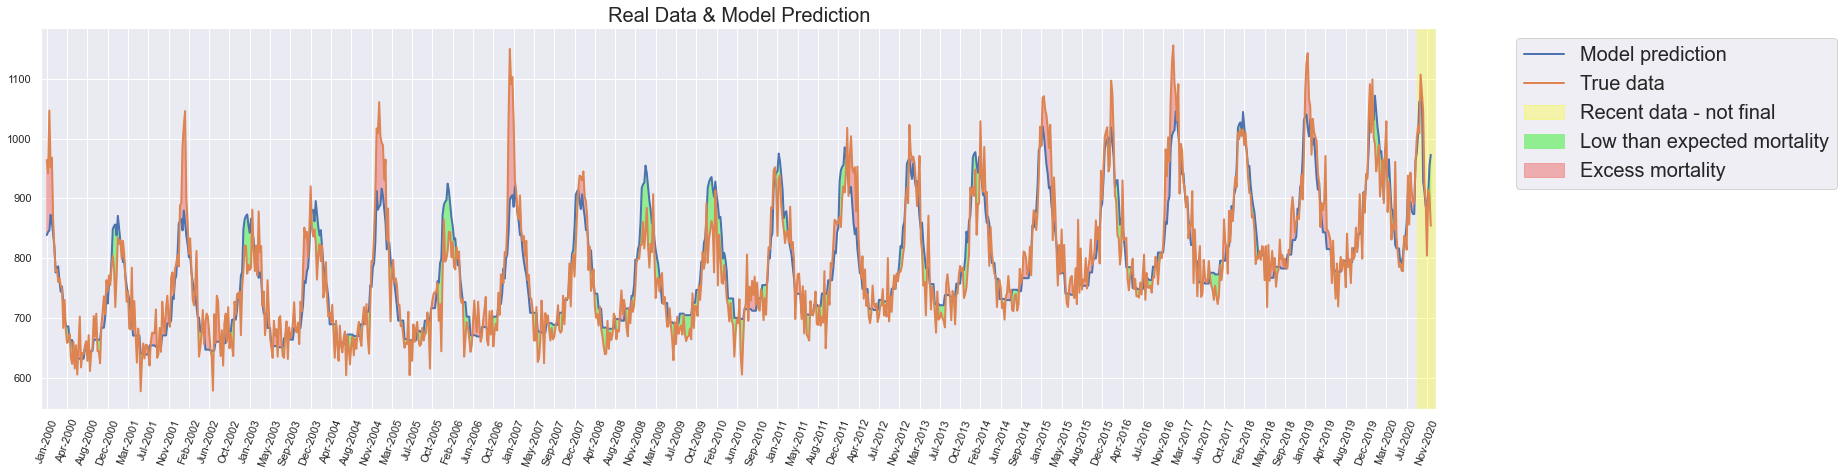

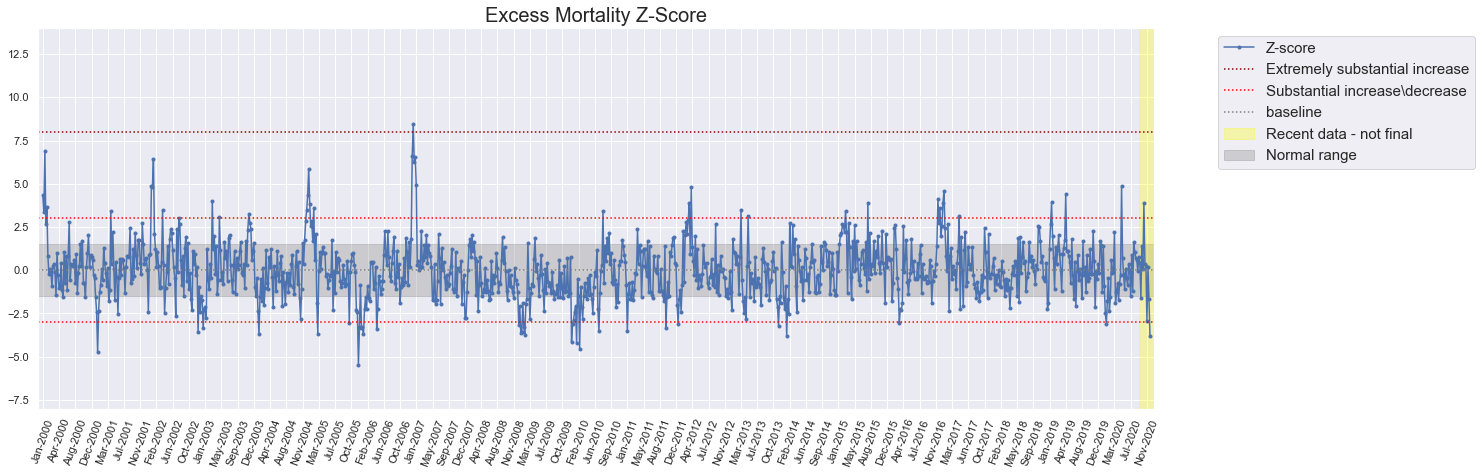

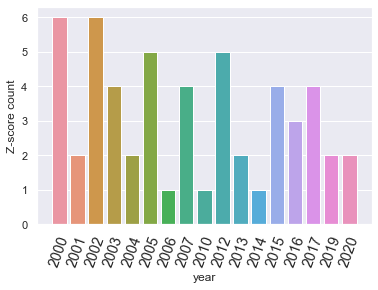

In [515]:
###################################
##  All population model         ##
## not including low P-val weeks ##
## including covid and flu       ##
###################################
#71'all_covid_data',  72 'all covid tests', 73'positive rate', 74'last week covid cases',  75 'last week covid tests',
#        76 'last week positive rate', 77 'confirmed flu cases']

#After removing some weeks, other weeks became less significant, so I removed them as well


updated_variables = pd.concat((variables.iloc[:,:33],variables.iloc[:,64:]), axis = 1)
poi_model = sm.GLM(death_count, np.array(updated_variables), family=sm.families.Poisson())
poi_model_res = poi_model.fit()
poi_model_res.summary()

#plot covid and flu P-val
degrees = 70
fig = plt.figure()
ax = plt.gca()
sns.barplot(variables.columns[71:], poi_model_res.pvalues[-7:])
fig.set_size_inches(25, 7)
plt.xticks(rotation=degrees, size = "large")
plt.axhline(0.025, color = "red")
plt.show()

#model without bad P-val
updated_variables = updated_variables.drop(labels = ["last week covid cases", "last week covid tests", 
                                                     "confirmed flu cases", "all covid tests"], axis = 1)
poi_model = sm.GLM(death_count, np.array(updated_variables), family=sm.families.Poisson())
poi_model_res = poi_model.fit()
print(poi_model_res.summary())

predictions, z_score, times = calc_prediction(poi_model_res, updated_variables, death_count)
draw_model(predictions, death_count, times)
draw_z_score(z_score, times)

#top 5 percent excess mortality 
top_alpha_excess_mortality(z_score, times, 0.05)



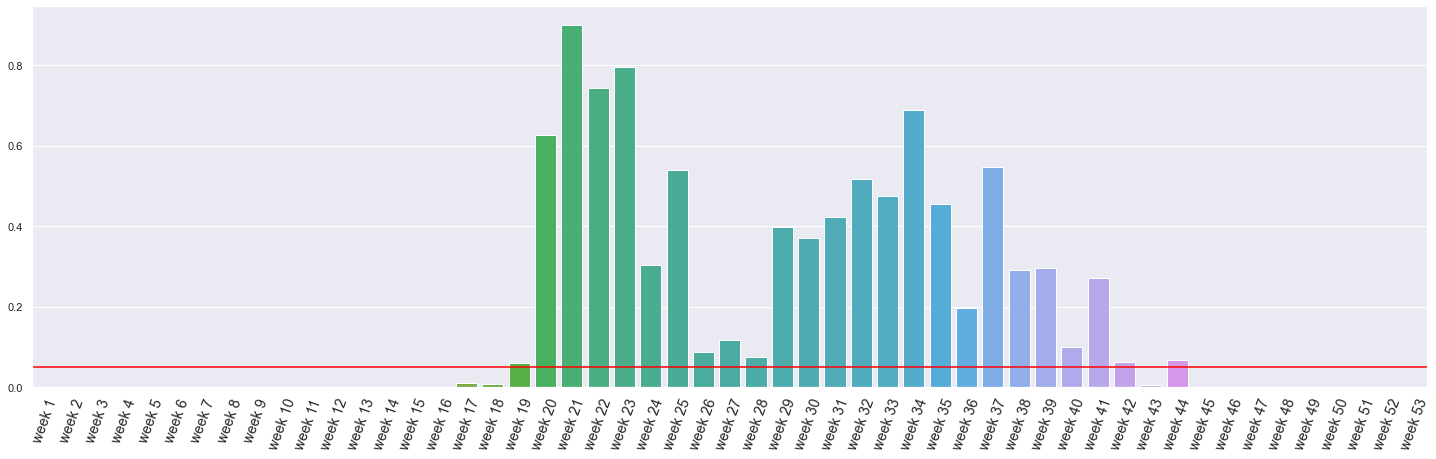

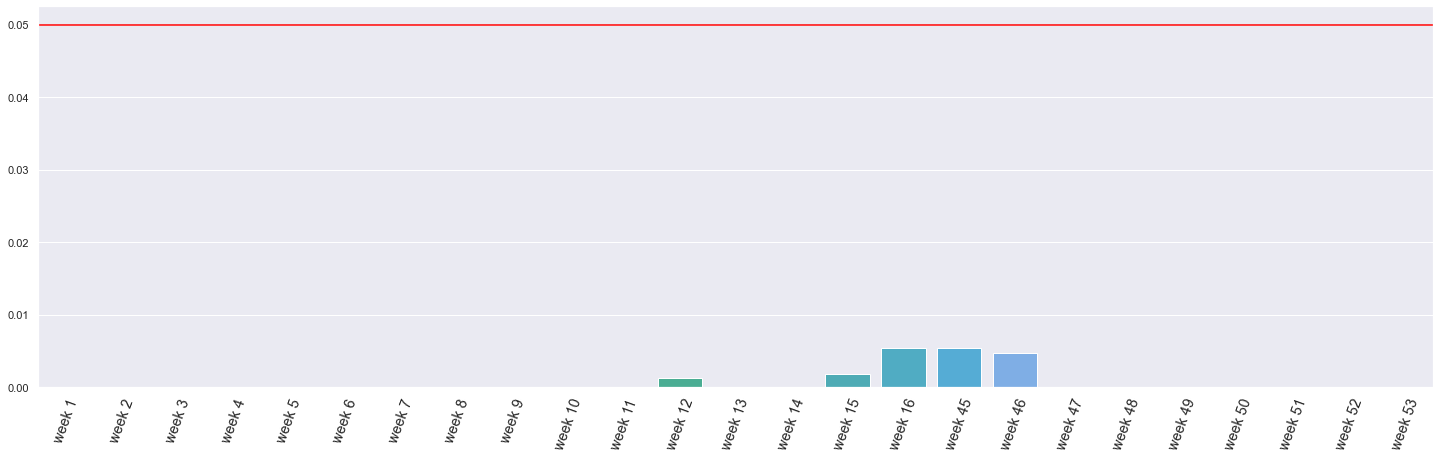

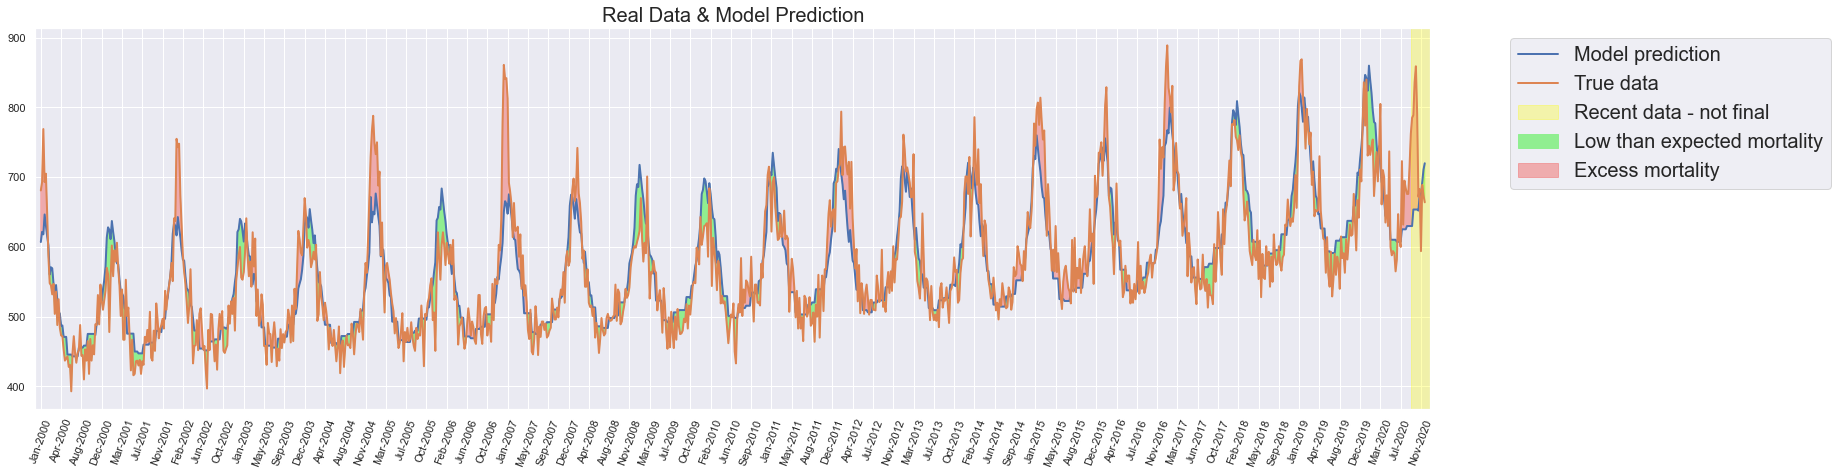

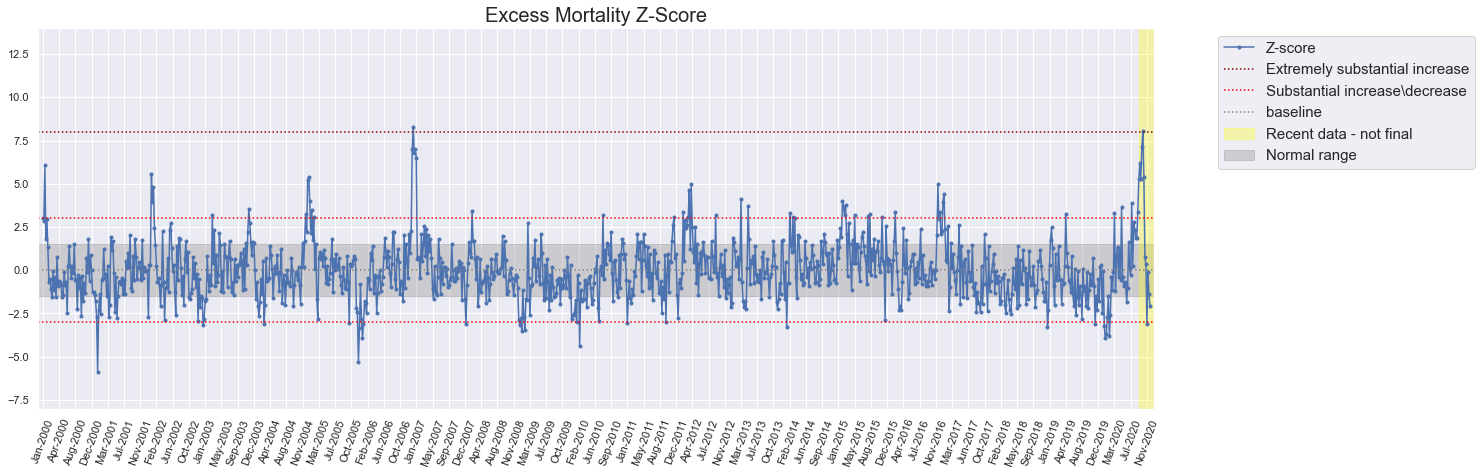

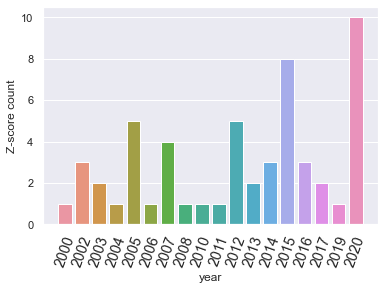

In [630]:
#############################
## elderly population model##
#############################

elderly_death_count_path = "D:\\אישי\\תמותת יתר\\death numbers\\over 70 death.csv"
elderly_pop_size_path = "D:\\אישי\\תמותת יתר\\pop size\\elderly pop size.csv"

variables, death_count, times = get_var_mat_and_death_vec(elderly_death_count_path, elderly_pop_size_path)

#poi model 
poi_model = sm.GLM(death_count, np.array(variables.iloc[:, :71]), family=sm.families.Poisson())
poi_model_res = poi_model.fit()
poi_model_res.summary()

#plot weeks p values
degrees = 70
fig = plt.figure()
ax = plt.gca()
sns.barplot(variables.columns[18:71], poi_model_res.pvalues[18:])
fig.set_size_inches(25, 7)
plt.xticks(rotation=degrees, size = "large")
plt.axhline(0.05, color = "red")

plt.show()

#removing weeks without sig.
updated_variables = pd.concat((variables.loc[:, :"week 16"], variables.loc[:, "week 45":"week 53"]), axis = 1)

poi_model = sm.GLM(death_count, np.array(updated_variables), family=sm.families.Poisson())
poi_model_res = poi_model.fit()
poi_model_res.summary()

#plot p values
degrees = 70
fig = plt.figure()
ax = plt.gca()
sns.barplot(updated_variables.columns[18:], poi_model_res.pvalues[18:])
fig.set_size_inches(25, 7)
plt.xticks(rotation=degrees, size = "large")
plt.axhline(0.05, color = "red")

predictions, z_score, times = calc_prediction(poi_model_res, updated_variables, death_count)
draw_model(predictions, death_count, times)
draw_z_score(z_score, times)

#top 5 percent excess mortality 
top_alpha_excess_mortality(z_score, times, 0.05)


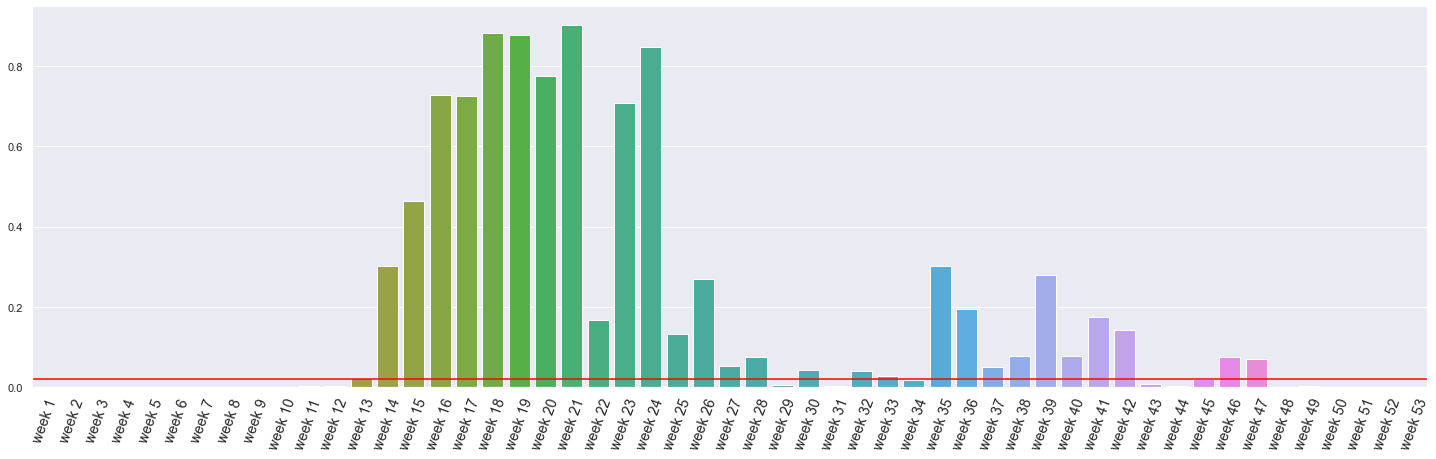

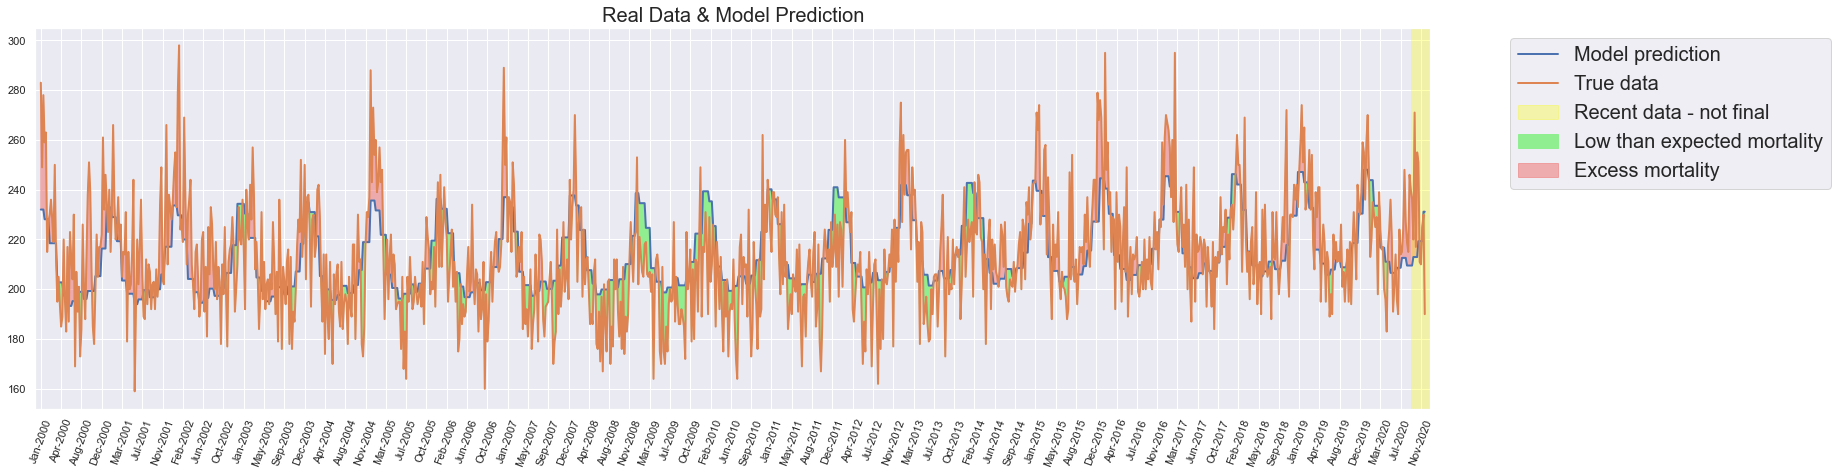

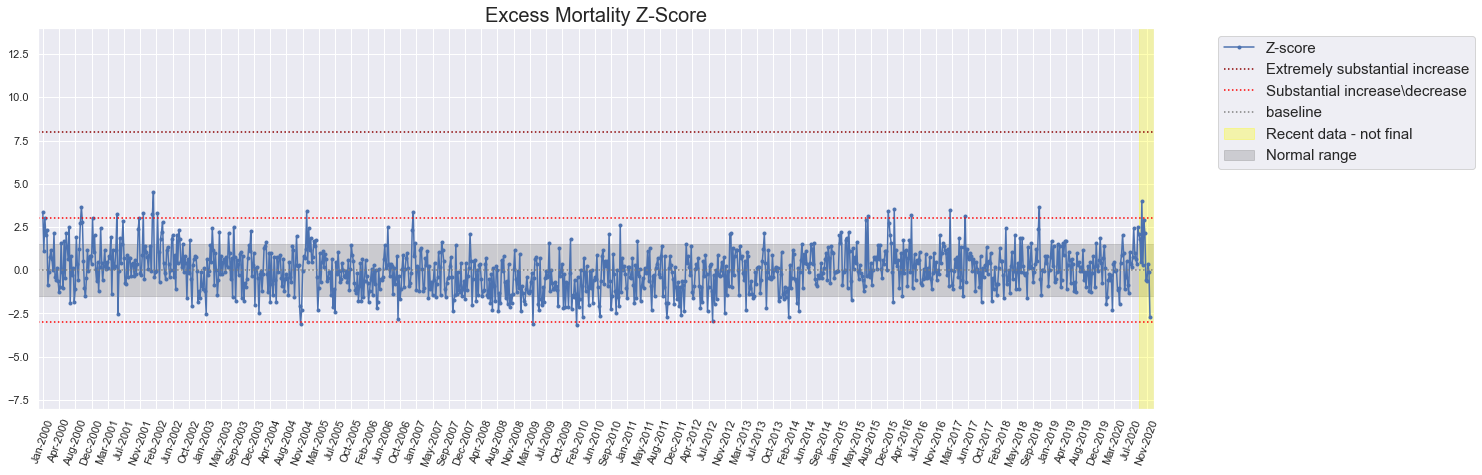

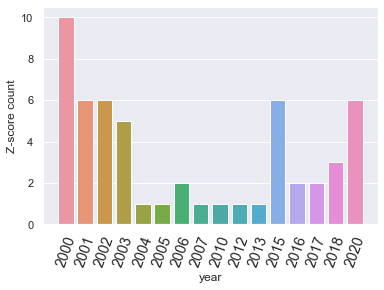

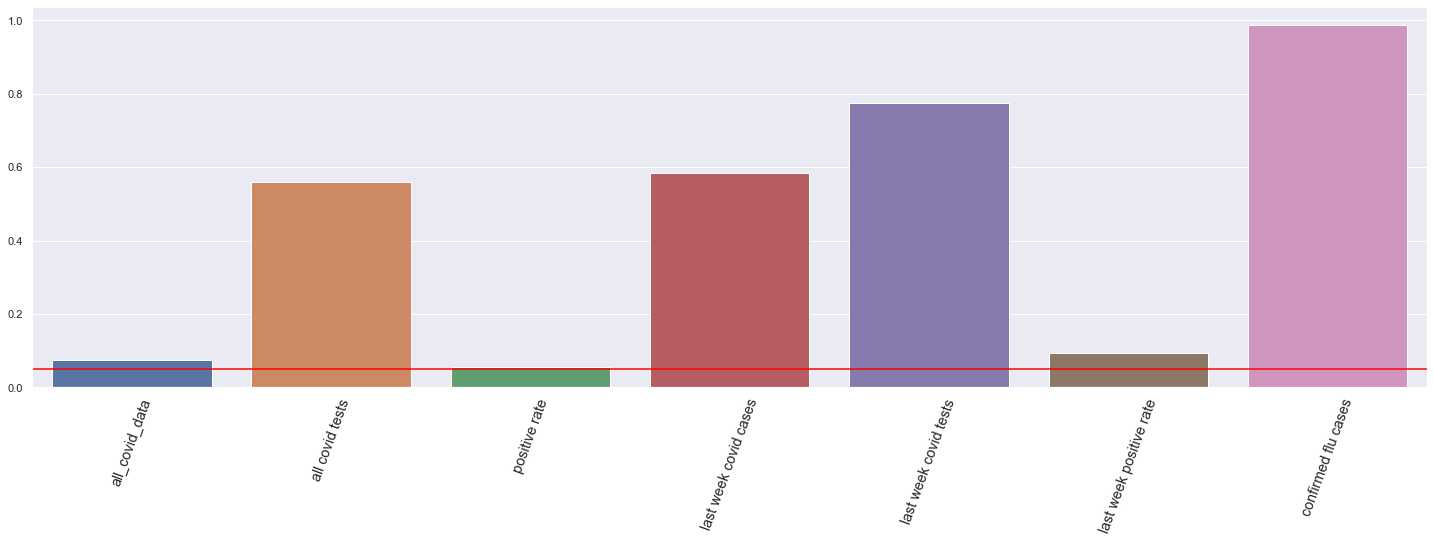

In [609]:
pop_output_loc = "D:\\אישי\\תמותת יתר\\pop size\\young pop size.csv"
death_output_loc = "D:\\אישי\\תמותת יתר\\death numbers\\under 70 death.csv"


write_young_pop(all_pop_size_path, elderly_pop_size_path, pop_output_loc)
write_young_death(all_pop_death_path, elderly_death_count_path, death_output_loc)

variables, death_count, times = get_var_mat_and_death_vec(death_output_loc, pop_output_loc)
poi_model = sm.GLM(death_count, np.array(variables.iloc[:, :71]), family=sm.families.Poisson())
poi_model_res = poi_model.fit()
poi_model_res.summary()

#plot weeks p values
degrees = 70
fig = plt.figure()
ax = plt.gca()
sns.barplot(variables.columns[18:71], poi_model_res.pvalues[18:])
fig.set_size_inches(25, 7)
plt.xticks(rotation=degrees, size = "large")
plt.axhline(0.02, color = "red")

plt.show()

#model without weeks variables
#updated_variables = pd.concat((variables.loc[:, :"week 1"], variables.loc[:, "week 52":"week 53"]), axis = 1)
updated_variables = variables.loc[:, :"month 12"]

poi_model = sm.GLM(death_count, np.array(updated_variables), family=sm.families.Poisson())
poi_model_res = poi_model.fit()
poi_model_res.summary()

predictions, z_score, times = calc_prediction(poi_model_res, updated_variables, death_count)
draw_model(predictions, death_count, times)
draw_z_score(z_score, times)

#top 5 percent excess mortality 
top_alpha_excess_mortality(z_score, times, 0.05)

#model with covid data
updated_variables = pd.concat((updated_variables, variables.loc[:,"all_covid_data":]), axis = 1)
poi_model = sm.GLM(death_count, np.array(updated_variables), family=sm.families.Poisson())
poi_model_res = poi_model.fit()
poi_model_res.summary()

#plot p values
degrees = 70
fig = plt.figure()
ax = plt.gca()
sns.barplot(updated_variables.columns[-7:], poi_model_res.pvalues[-7:])
fig.set_size_inches(25, 7)
plt.xticks(rotation=degrees, size = "large")
plt.axhline(0.05, color = "red")